In [1]:
!which python

/Users/taehwan/.conda/envs/tf/bin/python


In [2]:
import json

import pandas as pd
import requests
from tqdm import tqdm
import numpy as np

from config import API_KEY

### Get MVRV & MVRV-Z Score

In [3]:
def get_mvrv(symbol: str):
    res = requests.get(
        "https://api.glassnode.com/v1/metrics/market/mvrv",
        params={"a": symbol, "api_key": API_KEY},
    )
    mvrv_df = pd.read_json(res.text, convert_dates=["t"])
    mvrv_df = mvrv_df.rename(columns={"v": "mvrv"})
    return mvrv_df

In [4]:
def get_mvrv_z(symbol: str):
    res = requests.get(
        "https://api.glassnode.com/v1/metrics/market/mvrv_z_score",
        params={"a": symbol, "api_key": API_KEY},
    )
    mvrv_z_df = pd.read_json(res.text, convert_dates=["t"])
    mvrv_z_df = mvrv_z_df.rename(columns={"v": "mvrv_z"})
    return mvrv_z_df

In [5]:
mvrv = get_mvrv('BTC')
mvrv_z = get_mvrv_z('BTC')

mvrv.index = mvrv.t
mvrv_z.index = mvrv_z.t

mvrv = mvrv.drop('t', axis=1)
mvrv_z = mvrv_z.drop('t', axis=1)

In [6]:
df = pd.merge(mvrv, mvrv_z, left_index=True, right_index=True, how='right')
df = df.dropna()
df = df[df.index >= '2011-01-01']

In [60]:
df.to_csv('mvrv.csv', index=True)

<AxesSubplot:xlabel='t'>

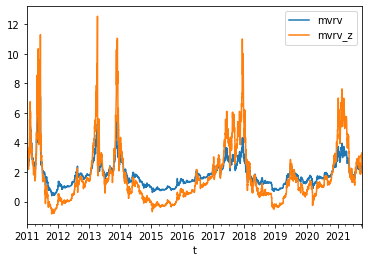

In [8]:
df.plot()

### Append BTC price in dataframe

In [9]:
def get_price(symbol: str):
    res = requests.get(
        "https://api.glassnode.com/v1/metrics/market/price_usd_close",
        params={"a": symbol, "api_key": API_KEY},
    )
    price_df = pd.read_json(res.text, convert_dates=["t"])
    price_df = price_df.rename(columns={"v": "price"})
    return price_df

In [10]:
price = get_price('BTC')
price.index = price.t
price = price.drop('t', axis=1)

In [11]:
price

,price
t,
2010-07-17,0.049510
2010-07-18,0.085840
2010-07-19,0.080800
2010-07-20,0.074733
2010-07-21,0.079210
...,...
2021-10-08,53884.290533
2021-10-09,55068.643546
2021-10-10,54675.093215


In [12]:
df = pd.merge(df, price, left_index=True, right_index=True, how='right')
df = df.dropna()
df = df[df.index >= '2011-01-01']

In [13]:
df

,mvrv,mvrv_z,price
t,,,
2011-01-01,2.619131,2.587964,0.300000
2011-01-02,2.581757,2.559242,0.299970
2011-01-03,2.534929,2.468358,0.295000
2011-01-04,2.549887,2.504235,0.298950
2011-01-05,2.557928,2.482870,0.298920
...,...,...,...
2021-10-07,2.519077,2.986311,53776.542871
2021-10-08,2.518883,2.990908,53884.290533
2021-10-09,2.528370,3.093188,55068.643546


In [14]:
def mean_of_mvrvs(mvrvs):
    mvrvs = list(set(sorted(mvrvs)))
    mean_mvrvs = []
    for i in range(len(mvrvs) - 1):
        mean_mvrvs.append((mvrvs[i] + mvrvs[i + 1]) / 2)
    return mean_mvrvs

In [15]:
def backtesting(mvrvs, thresholds, prices):
    yields = {}
    assert len(mvrvs) == len(prices)
    for threshold in thresholds:
        crypto = 0.0
        dollar = prices[0]
        # Todo: if `W` is very big, then we should use O(logN) algorithm.
        for i in range(len(mvrvs) - 1):
            assert mvrvs[i] != threshold
            if mvrvs[i] < threshold and dollar != 0:
                # long position(buy), under valued
                crypto = dollar / prices[i + 1]
                dollar = 0.0
            elif mvrvs[i] > threshold and crypto != 0:
                # short position(sell), highly valued
                dollar = crypto * prices[i + 1]
                crypto = 0.0
        if dollar == 0 and crypto != 0:
            dollar = crypto * prices[i + 1]
        yields[threshold] = dollar / prices[0]
    yields = sorted(yields.items(), key=lambda item: item[1], reverse=True)
    return yields[0]

In [16]:
def get_dsrv_6(df, key, W=30):
    df = list(df.itertuples(index=True))
    results = []
    for idx in range(W, len(df) + 1):
        subdf = df[idx - W:idx]
        if key == 'mvrv':
            mvrvs = [d.mvrv for d in subdf]
        elif key == 'mvrv_z':
            mvrvs = [d.mvrv_z for d in subdf]
        prices = [d.price for d in subdf]
        thresholds = mean_of_mvrvs(mvrvs)
        best_threshold = backtesting(mvrvs, thresholds, prices)
        
        time = subdf[-1].Index
        results.append(
            (time, best_threshold[0], np.log(best_threshold[0]), best_threshold[1], prices[-1], np.log(prices[-1]))
        )
    df = pd.DataFrame(results, columns=['t', 'best_threshold', 'log_best_threshold', 'yield', 'price', 'log_price'])
    df.index = df.t
    df = df.drop('t', axis=1)
    return df

In [17]:
best_threshold_mvrv = get_dsrv_6(df, key='mvrv', W=30)

In [18]:
best_threshold_mvrv

,best_threshold,log_best_threshold,yield,price,log_price
t,,,,,
2011-01-30,2.970892,1.088862,2.147257,0.479850,-0.734282
2011-01-31,2.970892,1.088862,2.503087,0.550100,-0.597655
2011-02-01,2.972299,1.089336,3.177791,0.707730,-0.345693
2011-02-02,2.962187,1.085928,3.178110,0.716000,-0.334075
2011-02-03,2.962187,1.085928,3.187922,0.696390,-0.361845
...,...,...,...,...,...
2021-10-07,2.261230,0.815909,1.307781,53776.542871,10.892593
2021-10-08,2.261230,0.815909,1.351163,53884.290533,10.894594
2021-10-09,2.261230,0.815909,1.343402,55068.643546,10.916336


<AxesSubplot:xlabel='t'>

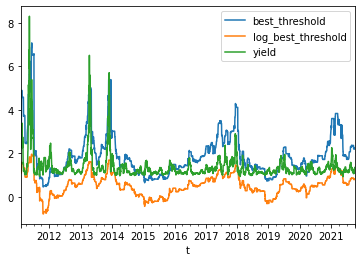

In [19]:
best_threshold_mvrv.drop(['price', 'log_price'], axis=1).plot()

<AxesSubplot:xlabel='t'>

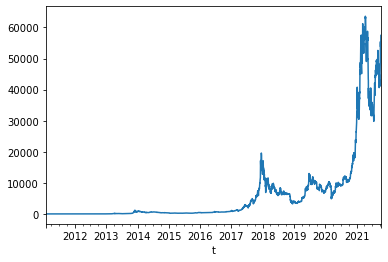

In [20]:
best_threshold_mvrv.price.plot()

In [21]:
best_threshold_mvrv_z = get_dsrv_6(df, key='mvrv_z', W=30)

/var/folders/tj/zzml3jqj5wnbjsgm40t4z_880000gn/T/ipykernel_41809/4054845264.py:16: RuntimeWarning: invalid value encountered in log
  (time, best_threshold[0], np.log(best_threshold[0]), best_threshold[1], prices[-1], np.log(prices[-1]))


<AxesSubplot:xlabel='t'>

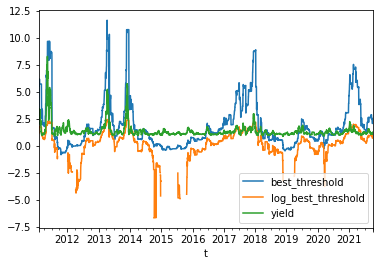

In [22]:
best_threshold_mvrv_z.drop(['price', 'log_price'], axis=1).plot()

<AxesSubplot:xlabel='t'>

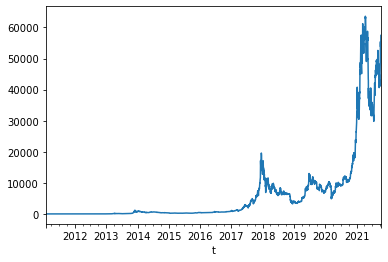

In [23]:
best_threshold_mvrv_z.price.plot()

### Stationary check

Find best `W` using Granger causality test check

In [26]:
# ADF Test on each column of 1st Differences Dataframe
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    # print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    # print(f' Significance Level    = {signif}')
    # print(f' Test Statistic        = {output["test_statistic"]}')
    # print(f' No. Lags Chosen       = {output["n_lags"]}')

    # for key,val in r[4].items():
    #    print(f' Critical value {adjust(key)} = {round(val, 3)}')
    
    return {
        "res" : True if p_value <= signif else False,
        "p-value" : p_value
    }

In [29]:
from cointanalysis import CointAnalysis

def coint_test(A, B, signif=0.05):
    X = np.array([A, B]).T

    coint = CointAnalysis()
    coint.test(X)

    return {
        "res" : True if coint.pvalue_ <= signif else False,
        "p-value" : coint.pvalue_
    }

In [30]:
def z_score(df):
    cols = list(df.columns)
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

In [31]:
subdf = df[('2017-06-01 00:00:00' <= df.index) & (df.index <= '2021-10-12 00:00:00')]

In [57]:
subdf

,mvrv,mvrv_z,price
t,,,
2017-06-01,3.227408,5.063162,2417.941274
2017-06-02,3.244292,5.219581,2479.561657
2017-06-03,3.341226,5.352066,2543.872327
2017-06-04,3.317976,5.215265,2521.845868
2017-06-05,3.387519,5.641984,2695.033419
...,...,...,...
2021-10-07,2.519077,2.986311,53776.542871
2021-10-08,2.518883,2.990908,53884.290533
2021-10-09,2.528370,3.093188,55068.643546


In [33]:
start = subdf.index[0]
end = subdf.index[-1]

print(start, end)
for W in tqdm(range(2, 50)):
    best_threshold_mvrv = get_dsrv_6(subdf, key='mvrv', W=W)
    best_threshold_mvrv_z = z_score(df=best_threshold_mvrv)
    
    r1 = adfuller_test(best_threshold_mvrv_z.best_threshold_zscore)
    r2 = adfuller_test(best_threshold_mvrv_z.log_price_zscore)
    r3 = coint_test(best_threshold_mvrv_z.best_threshold_zscore, best_threshold_mvrv_z.log_price_zscore, signif=0.05)

    if r3['res']:
        best_threshold_mvrv_z_diff = (best_threshold_mvrv_z - best_threshold_mvrv_z.shift(1)).dropna()
        rr1 = adfuller_test(best_threshold_mvrv_z_diff.best_threshold_zscore, signif=0.05)
        rr2 = adfuller_test(best_threshold_mvrv_z_diff.log_price_zscore, signif=0.05)
        if rr1['res'] and rr2['res']:
            print('mvrv', W, r1, r2, r3, rr1, rr2)

2017-06-01 00:00:00 2021-10-11 00:00:00


  4%|█▊                                          | 2/48 [00:00<00:10,  4.48it/s]

mvrv 2 {'res': False, 'p-value': 0.1651} {'res': False, 'p-value': 0.8518} {'res': True, 'p-value': 0.02806482429122902} {'res': True, 'p-value': 0.0} {'res': True, 'p-value': 0.0}
mvrv 3 {'res': False, 'p-value': 0.2187} {'res': False, 'p-value': 0.8671} {'res': True, 'p-value': 0.0429046332869049} {'res': True, 'p-value': 0.0} {'res': True, 'p-value': 0.0}


 85%|████████████████████████████████████▋      | 41/48 [00:11<00:02,  2.36it/s]

mvrv 42 {'res': False, 'p-value': 0.1991} {'res': False, 'p-value': 0.7836} {'res': True, 'p-value': 0.03284329085276912} {'res': True, 'p-value': 0.0} {'res': True, 'p-value': 0.0}


 88%|█████████████████████████████████████▋     | 42/48 [00:12<00:02,  2.27it/s]

mvrv 43 {'res': False, 'p-value': 0.2144} {'res': False, 'p-value': 0.7324} {'res': True, 'p-value': 0.03001204199502739} {'res': True, 'p-value': 0.0} {'res': True, 'p-value': 0.0}


100%|███████████████████████████████████████████| 48/48 [00:15<00:00,  3.10it/s]


<AxesSubplot:xlabel='t'>

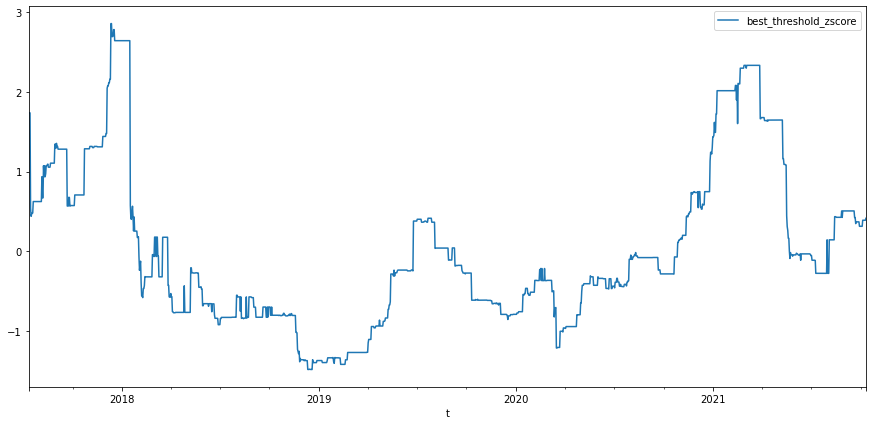

In [34]:
W = 42

best_threshold_mvrv = get_dsrv_6(subdf, key='mvrv', W=W)
best_threshold_mvrv_z = z_score(df=best_threshold_mvrv)
best_threshold_mvrv_z[['best_threshold_zscore']].plot(figsize=(15, 7))

<AxesSubplot:xlabel='t'>

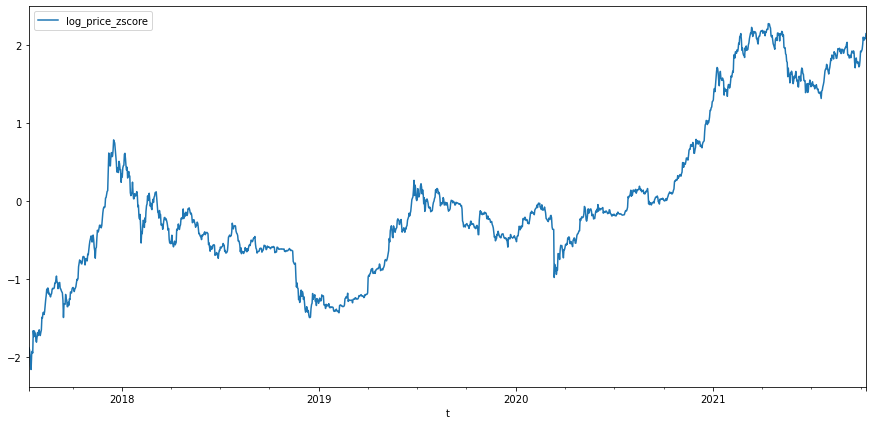

In [36]:
best_threshold_mvrv[['log_price_zscore']].plot(figsize=(15, 7))

In [48]:
W = 42

classes = {'up' : 0,  'same' : 0, 'down' : 0}

Xs = []
ys = []

for idx in range(W, len(best_threshold_mvrv_z) + 1):
    sub_best_threshold_mvrv_z = best_threshold_mvrv_z[idx - W:idx]
    best_threshold_zscore = sub_best_threshold_mvrv_z.best_threshold_zscore.values
    X = best_threshold_zscore[:-1]
    y = best_threshold_zscore[-1]
    
    Xs.append(best_threshold_zscore[:-1])
    ys.append([y])
    if X[-1] < y: # up
        classes['up'] += 1
    elif X[-1] > y: # down
        classes['down'] += 1
    else: # same
        classes['same'] += 1
        
X_train = np.asarray(Xs)
Y_train = np.asarray(ys)

In [37]:
classes

{'up': 220, 'same': 1074, 'down': 218}

In [59]:
filename = f"BTC_{W}.csv"
subdf.to_csv(filename)